In [1]:
from scipy.io import loadmat
import torch
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
import json
from glob import glob

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from extractor import ViTExtractor
from inspect_similarity import chunk_cosine_sim
from correspondences import draw_correspondences

In [2]:
def resize(img, target_res, resize=True, to_pil=True):
    canvas = np.zeros([target_res, target_res, 3], dtype=np.uint8)
    original_width, original_height = img.size
    if original_height <= original_width:
        if resize:
            img = img.resize((target_res, int(np.around(target_res * original_height / original_width))), Image.Resampling.LANCZOS)
        width, height = img.size
        img = np.asarray(img)
        canvas[(width - height) // 2: (width + height) // 2] = img
    else:
        if resize:
            img = img.resize((int(np.around(target_res * original_width / original_height)), target_res), Image.Resampling.LANCZOS)
        width, height = img.size
        img = np.asarray(img)
        canvas[:, (height - width) // 2: (height + width) // 2] = img
    if to_pil:
        canvas = Image.fromarray(canvas)
    return canvas

def preprocess_kps_pad(kps, img_width, img_height, size):
    # Once an image has been pre-processed via border (or zero) padding,
    # the location of key points needs to be updated. This function applies
    # that pre-processing to the key points so they are correctly located
    # in the border-padded (or zero-padded) image.
    kps = kps.clone()
    scale = size / max(img_width, img_height)
    kps[:, [0, 1]] *= scale
    if img_height < img_width:
        new_h = int(np.around(size * img_height / img_width))
        offset_y = int((size - new_h) / 2)
        offset_x = 0
        kps[:, 1] += offset_y
    elif img_width < img_height:
        new_w = int(np.around(size * img_width / img_height))
        offset_x = int((size - new_w) / 2)
        offset_y = 0
        kps[:, 0] += offset_x
    else:
        offset_x = 0
        offset_y = 0
    kps *= kps[:, 2:3]  # zero-out any non-visible key points
    return kps, offset_x, offset_y, scale


def load_spair_data(path, size=256, category='cat', split='test', subsample=None):
    pairs = sorted(glob(f'{path}/PairAnnotation/{split}/*:{category}.json'))
    if subsample is not None and subsample > 0:
        pairs = [pairs[ix] for ix in np.random.choice(len(pairs), subsample)]
    print(f'Number of SPairs for {category} = {len(pairs)}')
    files = []
    thresholds = []
    category_anno = list(glob(f'{path}/ImageAnnotation/{category}/*.json'))[0]
    with open(category_anno) as f:
        num_kps = len(json.load(f)['kps'])
    print(f'Number of SPair key points for {category} <= {num_kps}')
    kps = []
    blank_kps = torch.zeros(num_kps, 3)
    for pair in pairs:
        with open(pair) as f:
            data = json.load(f)
        assert category == data["category"]
        assert data["mirror"] == 0
        source_fn = f'{path}/JPEGImages/{category}/{data["src_imname"]}'
        target_fn = f'{path}/JPEGImages/{category}/{data["trg_imname"]}'
        source_bbox = np.asarray(data["src_bndbox"])
        target_bbox = np.asarray(data["trg_bndbox"])
        # The source thresholds aren't actually used to evaluate PCK on SPair-71K, but for completeness
        # they are computed as well:
        thresholds.append(max(source_bbox[3] - source_bbox[1], source_bbox[2] - source_bbox[0]))
        thresholds.append(max(target_bbox[3] - target_bbox[1], target_bbox[2] - target_bbox[0]))

        source_size = data["src_imsize"][:2]  # (W, H)
        target_size = data["trg_imsize"][:2]  # (W, H)

        kp_ixs = torch.tensor([int(id) for id in data["kps_ids"]]).view(-1, 1).repeat(1, 3)
        source_raw_kps = torch.cat([torch.tensor(data["src_kps"], dtype=torch.float), torch.ones(kp_ixs.size(0), 1)], 1)
        source_kps = blank_kps.scatter(dim=0, index=kp_ixs, src=source_raw_kps)
        source_kps, src_x, src_y, src_scale = preprocess_kps_pad(source_kps, source_size[0], source_size[1], size)
        target_raw_kps = torch.cat([torch.tensor(data["trg_kps"], dtype=torch.float), torch.ones(kp_ixs.size(0), 1)], 1)
        target_kps = blank_kps.scatter(dim=0, index=kp_ixs, src=target_raw_kps)
        target_kps, trg_x, trg_y, trg_scale = preprocess_kps_pad(target_kps, target_size[0], target_size[1], size)

        kps.append(source_kps)
        kps.append(target_kps)
        files.append(source_fn)
        files.append(target_fn)

    kps = torch.stack(kps)
    used_kps, = torch.where(kps[:, :, 2].any(dim=0))
    kps = kps[:, used_kps, :]
    print(f'Final number of used key points: {kps.size(1)}')
    return files, kps


In [3]:
files, kps = load_spair_data('/mnt/data/SPair-71k', subsample=20)

Number of SPairs for cat = 20
Number of SPair key points for cat <= 30
Final number of used key points: 15


## Testing single Image (Skip for PCK computation)

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

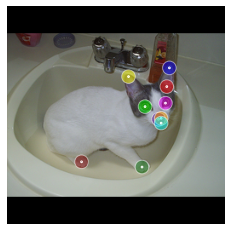

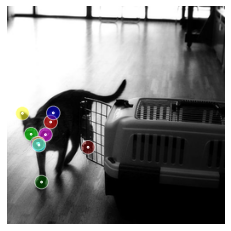

In [38]:
pair_idx = 0
img_size = 256

src_img = Image.open(files[2*pair_idx]).convert('RGB')
src_img = resize(src_img, img_size, resize=True, to_pil=True)
src_kps = kps[2*pair_idx]

trg_img = Image.open(files[2*pair_idx+1]).convert('RGB')
trg_img = resize(trg_img, img_size, resize=True, to_pil=True)
trg_kps = kps[2*pair_idx+1]

vis = src_kps[:, 2] * trg_kps[:, 2] > 0
draw_correspondences(src_kps[vis][:, [1,0]], trg_kps[vis][:, [1,0]], src_img, trg_img)

In [40]:
img_size = 256
layer = 9
facet = 'key'
bin = True
stride = 4
model_type = 'dino_vits8'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
extractor = ViTExtractor(model_type, stride, device=device)
patch_size = extractor.model.patch_embed.patch_size
num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)

with torch.no_grad():
    src_img_batch = extractor.preprocess_pil(src_img)
    trg_img_batch = extractor.preprocess_pil(trg_img)

    src_desc = extractor.extract_descriptors(src_img_batch.to(device), layer, facet, bin)
    trg_desc = extractor.extract_descriptors(trg_img_batch.to(device), layer, facet, bin)
    similarities = chunk_cosine_sim(src_desc, trg_desc)[0, 0]

Using cache found in /home/kampta/.cache/torch/hub/facebookresearch_dino_main


In [41]:
src_y, src_x = (src_kps[vis][:, 1]+0.5).numpy(), (src_kps[vis][:, 0]+0.5).numpy()
src_y_patch = (num_patches / img_size * src_y).astype(np.int32)
src_x_patch = (num_patches / img_size * src_x).astype(np.int32)

In [42]:
src_patch_idx = num_patches * src_y_patch + src_x_patch
nn = torch.argmax(similarities[src_patch_idx], dim=1)

In [43]:
nn_y_patch, nn_x_patch = nn // num_patches, nn % num_patches

/tmp/ipykernel_13698/298713991.py:1: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_patch, nn_x_patch = nn // num_patches, nn % num_patches


In [44]:
nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
src_kps_transfer = torch.stack([nn_x, nn_y]).permute(1, 0)

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

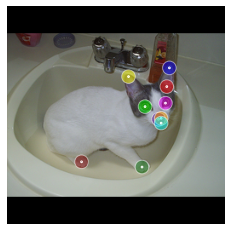

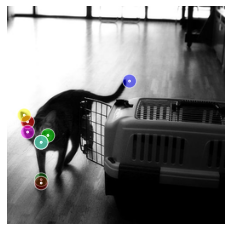

In [45]:
draw_correspondences(src_kps[vis][:, [1,0]], src_kps_transfer[:, [1,0]], src_img, trg_img)

## PCK for a single category (Skip for PCK computation for all categories)

In [6]:
gt_correspondences = []
pred_correspondences = []
img_size = 256
N = len(files) // 2
pbar = tqdm(total=N)

img_size = 256
layer = 9
facet = 'key'
bin = True
stride = 4
model_type = 'dino_vits8'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
extractor = ViTExtractor(model_type, stride, device=device)
patch_size = extractor.model.patch_embed.patch_size
num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)

for pair_idx in range(N):
    # Load image 1
    img1 = Image.open(files[2*pair_idx]).convert('RGB')
    img1 = resize(img1, img_size, resize=True, to_pil=True)
    img1_kps = kps[2*pair_idx]

    # Get patch index for the keypoints
    img1_y, img1_x = img1_kps[:, 1].numpy(), img1_kps[:, 0].numpy()
    img1_y_patch = (num_patches / img_size * img1_y).astype(np.int32)
    img1_x_patch = (num_patches / img_size * img1_x).astype(np.int32)
    img1_patch_idx = num_patches * img1_y_patch + img1_x_patch
    
    # Load image 2
    img2 = Image.open(files[2*pair_idx+1]).convert('RGB')
    img2 = resize(img2, img_size, resize=True, to_pil=True)
    img2_kps = kps[2*pair_idx+1]

    # Get patch index for the keypoints
    img2_y, img2_x = img2_kps[:, 1].numpy(), img2_kps[:, 0].numpy()
    img2_y_patch = (num_patches / img_size * img2_y).astype(np.int32)
    img2_x_patch = (num_patches / img_size * img2_x).astype(np.int32)
    img2_patch_idx = num_patches * img2_y_patch + img2_x_patch
    

    with torch.no_grad():
        img1_batch = extractor.preprocess_pil(img1)
        img1_desc = extractor.extract_descriptors(img1_batch.to(device), layer, facet, bin)

        img2_batch = extractor.preprocess_pil(img2)
        img2_desc = extractor.extract_descriptors(img2_batch.to(device), layer, facet, bin)

    # Get mutual visibility
    vis = img1_kps[:, 2] * img2_kps[:, 2] > 0

    # Get similarity matrix
    sim_1_to_2 = chunk_cosine_sim(img1_desc, img2_desc).squeeze()
    
    # Get nearest neighors
    nn_1_to_2 = torch.argmax(sim_1_to_2[img1_patch_idx], dim=1)
    nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
    nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
    nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
    kps_1_to_2 = torch.stack([nn_x, nn_y]).permute(1, 0)

    gt_correspondences.append(img1_kps[vis][:, [1,0]])
    pred_correspondences.append(kps_1_to_2[vis][:, [1,0]])
    pbar.update(1)

gt_correspondences = torch.cat(gt_correspondences, dim=0).cpu()
pred_correspondences = torch.cat(pred_correspondences, dim=0).cpu()

  0%|                                                        | 0/20 [00:00<?, ?it/s]Using cache found in /home/kampta/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_19792/4112628774.py:57: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
100%|███████████████████████████████████████████████| 20/20 [03:36<00:00, 10.64s/it]

In [7]:
alpha = torch.tensor([0.1, 0.05, 0.01])
correct = torch.zeros(len(alpha))

err = (pred_correspondences - gt_correspondences).norm(dim=-1)
err = err.unsqueeze(0).repeat(len(alpha), 1)
threshold = alpha * img_size
correct = err < threshold.unsqueeze(-1)
correct = correct.sum(dim=-1) / len(gt_correspondences)

alpha2pck = zip(alpha.tolist(), correct.tolist())
print(' | '.join([f'PCK-Transfer@{alpha:.2f}: {pck_alpha * 100:.2f}%'
                  for alpha, pck_alpha in alpha2pck]))

PCK-Transfer@0.10: 15.89% | PCK-Transfer@0.05: 2.34% | PCK-Transfer@0.01: 0.00%


## PCK for all categories

In [3]:
data_dir = '/mnt/data/SPair-71k/'
categories = os.listdir(os.path.join(data_dir, 'ImageAnnotation'))

In [5]:
img_size = 256
layer = 9
facet = 'key'
bin = False
stride = 4
model_type = 'dino_vits8'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
extractor = ViTExtractor(model_type, stride, device=device)
patch_size = extractor.model.patch_embed.patch_size
num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)

Using cache found in /home/kampta/.cache/torch/hub/facebookresearch_dino_main


In [11]:
def compute_pck(files, kps):
    gt_correspondences = []
    pred_correspondences = []
    N = len(files) // 2
    pbar = tqdm(total=N)

    for pair_idx in range(N):
        # Load image 1
        img1 = Image.open(files[2*pair_idx]).convert('RGB')
        img1 = resize(img1, img_size, resize=True, to_pil=True)
        img1_kps = kps[2*pair_idx]

        # Get patch index for the keypoints
        img1_y, img1_x = img1_kps[:, 1].numpy(), img1_kps[:, 0].numpy()
        img1_y_patch = (num_patches / img_size * img1_y).astype(np.int32)
        img1_x_patch = (num_patches / img_size * img1_x).astype(np.int32)
        img1_patch_idx = num_patches * img1_y_patch + img1_x_patch

        # Load image 2
        img2 = Image.open(files[2*pair_idx+1]).convert('RGB')
        img2 = resize(img2, img_size, resize=True, to_pil=True)
        img2_kps = kps[2*pair_idx+1]

        # Get patch index for the keypoints
        img2_y, img2_x = img2_kps[:, 1].numpy(), img2_kps[:, 0].numpy()
        img2_y_patch = (num_patches / img_size * img2_y).astype(np.int32)
        img2_x_patch = (num_patches / img_size * img2_x).astype(np.int32)
        img2_patch_idx = num_patches * img2_y_patch + img2_x_patch


        with torch.no_grad():
            img1_batch = extractor.preprocess_pil(img1)
            img1_desc = extractor.extract_descriptors(img1_batch.to(device), layer, facet, bin)

            img2_batch = extractor.preprocess_pil(img2)
            img2_desc = extractor.extract_descriptors(img2_batch.to(device), layer, facet, bin)

        # Get mutual visibility
        vis = img1_kps[:, 2] * img2_kps[:, 2] > 0

        # Get similarity matrix
        sim_1_to_2 = chunk_cosine_sim(img1_desc, img2_desc).squeeze()

        # Get nearest neighors
        nn_1_to_2 = torch.argmax(sim_1_to_2[img1_patch_idx], dim=1)
        nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
        nn_x = (nn_x_patch - 1) * stride + stride + patch_size // 2 - .5
        nn_y = (nn_y_patch - 1) * stride + stride + patch_size // 2 - .5
        kps_1_to_2 = torch.stack([nn_x, nn_y]).permute(1, 0)

        gt_correspondences.append(img1_kps[vis][:, [1,0]])
        pred_correspondences.append(kps_1_to_2[vis][:, [1,0]])
        pbar.update(1)

    gt_correspondences = torch.cat(gt_correspondences, dim=0).cpu()
    pred_correspondences = torch.cat(pred_correspondences, dim=0).cpu()
    alpha = torch.tensor([0.1, 0.05, 0.01])
    correct = torch.zeros(len(alpha))

    err = (pred_correspondences - gt_correspondences).norm(dim=-1)
    err = err.unsqueeze(0).repeat(len(alpha), 1)
    threshold = alpha * img_size
    correct = err < threshold.unsqueeze(-1)
    correct = correct.sum(dim=-1) / len(gt_correspondences)

    alpha2pck = zip(alpha.tolist(), correct.tolist())
    print(' | '.join([f'PCK-Transfer@{alpha:.2f}: {pck_alpha * 100:.2f}%'
                      for alpha, pck_alpha in alpha2pck]))
    return correct

In [16]:
pcks = []
for cat in categories:
    files, kps = load_spair_data(data_dir, category=cat, subsample=20)
    pck = compute_pck(files, kps)
    pcks.append(pck[0])
    
print(f"Average PCK: {np.average(pcks) * 100:.2f}")

Number of SPairs for motorbike = 20
Number of SPair key points for motorbike <= 30
Final number of used key points: 12


  0%|                                                        | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_20853/2416237554.py:46: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  nn_y_patch, nn_x_patch = nn_1_to_2 // num_patches, nn_1_to_2 % num_patches
100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.46it/s]


PCK-Transfer@0.10: 13.76% | PCK-Transfer@0.05: 3.67% | PCK-Transfer@0.01: 0.00%
Number of SPairs for tvmonitor = 20
Number of SPair key points for tvmonitor <= 30
Final number of used key points: 16


100%|███████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


PCK-Transfer@0.10: 8.81% | PCK-Transfer@0.05: 1.32% | PCK-Transfer@0.01: 0.00%
Number of SPairs for horse = 20
Number of SPair key points for horse <= 30
Final number of used key points: 17


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


PCK-Transfer@0.10: 21.28% | PCK-Transfer@0.05: 11.35% | PCK-Transfer@0.01: 0.00%
Number of SPairs for bus = 20
Number of SPair key points for bus <= 30
Final number of used key points: 24


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


PCK-Transfer@0.10: 30.07% | PCK-Transfer@0.05: 10.49% | PCK-Transfer@0.01: 0.70%
Number of SPairs for dog = 20
Number of SPair key points for dog <= 30
Final number of used key points: 15


100%|███████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


PCK-Transfer@0.10: 16.23% | PCK-Transfer@0.05: 5.84% | PCK-Transfer@0.01: 0.00%
Number of SPairs for bird = 20
Number of SPair key points for bird <= 30
Final number of used key points: 15


100%|███████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


PCK-Transfer@0.10: 15.97% | PCK-Transfer@0.05: 4.20% | PCK-Transfer@0.01: 0.00%
Number of SPairs for car = 20
Number of SPair key points for car <= 30
Final number of used key points: 29


100%|███████████████████████████████████████████████| 20/20 [00:14<00:00,  1.42it/s]


PCK-Transfer@0.10: 19.57% | PCK-Transfer@0.05: 4.35% | PCK-Transfer@0.01: 0.00%
Number of SPairs for boat = 20
Number of SPair key points for boat <= 30
Final number of used key points: 14


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


PCK-Transfer@0.10: 14.29% | PCK-Transfer@0.05: 4.40% | PCK-Transfer@0.01: 0.00%
Number of SPairs for sheep = 20
Number of SPair key points for sheep <= 30
Final number of used key points: 18


100%|███████████████████████████████████████████████| 20/20 [00:14<00:00,  1.41it/s]


PCK-Transfer@0.10: 19.13% | PCK-Transfer@0.05: 3.48% | PCK-Transfer@0.01: 0.00%
Number of SPairs for cow = 20
Number of SPair key points for cow <= 30
Final number of used key points: 21


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


PCK-Transfer@0.10: 20.00% | PCK-Transfer@0.05: 4.44% | PCK-Transfer@0.01: 0.56%
Number of SPairs for bicycle = 20
Number of SPair key points for bicycle <= 30
Final number of used key points: 12


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.44it/s]


PCK-Transfer@0.10: 7.48% | PCK-Transfer@0.05: 3.74% | PCK-Transfer@0.01: 0.93%
Number of SPairs for chair = 20
Number of SPair key points for chair <= 30
Final number of used key points: 12


100%|███████████████████████████████████████████████| 20/20 [00:14<00:00,  1.43it/s]


PCK-Transfer@0.10: 14.88% | PCK-Transfer@0.05: 2.48% | PCK-Transfer@0.01: 0.83%
Number of SPairs for cat = 20
Number of SPair key points for cat <= 30
Final number of used key points: 15


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.48it/s]


PCK-Transfer@0.10: 14.15% | PCK-Transfer@0.05: 4.72% | PCK-Transfer@0.01: 0.00%
Number of SPairs for bottle = 20
Number of SPair key points for bottle <= 30
Final number of used key points: 10


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


PCK-Transfer@0.10: 18.57% | PCK-Transfer@0.05: 3.57% | PCK-Transfer@0.01: 0.00%
Number of SPairs for aeroplane = 20
Number of SPair key points for aeroplane <= 30
Final number of used key points: 25


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


PCK-Transfer@0.10: 15.73% | PCK-Transfer@0.05: 3.93% | PCK-Transfer@0.01: 0.00%
Number of SPairs for train = 20
Number of SPair key points for train <= 30
Final number of used key points: 18


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]


PCK-Transfer@0.10: 15.84% | PCK-Transfer@0.05: 3.62% | PCK-Transfer@0.01: 0.00%
Number of SPairs for person = 20
Number of SPair key points for person <= 30
Final number of used key points: 18


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.45it/s]


PCK-Transfer@0.10: 6.48% | PCK-Transfer@0.05: 2.78% | PCK-Transfer@0.01: 0.00%
Number of SPairs for pottedplant = 20
Number of SPair key points for pottedplant <= 30
Final number of used key points: 9


100%|███████████████████████████████████████████████| 20/20 [00:13<00:00,  1.43it/s]

PCK-Transfer@0.10: 7.00% | PCK-Transfer@0.05: 2.00% | PCK-Transfer@0.01: 0.00%
Average PCK: 15.51
